In [1]:
# Luís 16/04/2023

# This example was taken and adapted from https://doi.org/10.48550/arXiv.2210.09060

# I followed the original code, with some minor modifications to make it more readable
# and organized it as a Jupyter Notebook.

# Still need to understand better:

# Python code: "with" statements; @tf.function
# Implementation: Dif and L_BFGS_B classes; tf.GradientTape (for "automatic differentiation")

# Note:
# I should do some more research into "Automatic Differentiation", in order to really understand it.

# I will keep exploring the implementation of this code by doing a similar analysis on the
# 3D example, so that I can later extrapolate and implement on a case of interest of mine.

# 2D Plate under traction solved using a PINN

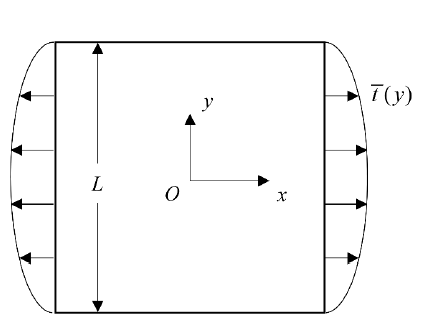

The problem at hand can be found at https://doi.org/10.48550/arXiv.2210.09060.

It basically consists of a plate under tension, as seen in the previous figure. The distributed force has a cossine shape. Due to its symmetry, only a quarter of the plate will be here modelled, and the necessary boundary conditions will be applied.

We will be using the Collocation loss as loss function (which includes the residual from the equilibrium equation and boundary condition imposition).

In [2]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import numpy as np
import math
import time
import scipy.optimize
import matplotlib.pyplot as plt

## Before training our PINN, we will:
    1. Load the problem information;
    2. Build up the FNNs;
    3. Build up the PINN;
    4. Initialize the L-BFGS-B optimiser.

--------------------------------------------------------------------------------------------------------------------

    Some of the important variables:

    Name        Type                    Info.

    [ns]        [int]                   : Total number of sample points;
    [dx]        [float]                 : Sample points interval;
    [xy]        [Array of float32]      : Coordinates of all the sample points;
    [xy_u]      [Array of float32]      : Coordinates of the sample points on the upper boundary of the plate;
    [xy_b]      [Array of float32]      : Coordinates of the sample points on the bottom boundary of the plate;
    [xy_l]      [Array of float32]      : Coordinates of the sample points on the left boundary of the plate;
    [xy_r]      [Array of float32]      : Coordinates of the sample points on the right boundary of the plate;
    [x_train]   [List]                  : PINN input list, contains all the coordinates information;
    [s_u_x]     [Array of float32]      : x direction traction boundary condition on the top boundary of the plate;
    [s_u_y]     [Array of float32]      : y direction traction boundary condition on the top boundary of the plate;
    [s_b_x]     [Array of float32]      : x direction traction boundary condition on the bottom boundary of the plate;
    [s_b_y]     [Array of float32]      : y direction traction boundary condition on the bottom boundary of the plate;
    [s_l_x]     [Array of float32]      : x direction traction boundary condition on the left boundary of the plate;
    [s_l_y]     [Array of float32]      : y direction traction boundary condition on the left boundary of the plate;
    [s_r_x]     [Array of float32]      : x direction traction boundary condition on the right boundary of the plate;
    [s_r_y]     [Array of float32]      : y direction traction boundary condition on the right boundary of the plate;
    [y_train]   [List]                  : PINN boundary condition list, contains the traction boundary condition;
    [n_input]   [int]                   : Number of inputs for the FNN;
    [n_output]  [int]                   : Number of outputs for the FNN;
    [layers]    [list]                  : Size of the FNN;
    [acti_fun]  [str]                   : The activation function used after each layer;
                                                        Available options:
                                                        'tanh'
                                                        'sigmoid'
                                                        'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
    [k_init]    [str]                   : The kernel initialisation method.
    [NN_info]   [list]                  : Neural Network information list, contains the settings for the FNN;
    [E]         [float]                 : Young's module;
    [mu]        [float]                 : Poisson ratio.

### Load the problem information

In [4]:
### Define the number of sample points
ns_u = 51
ns_l = 51
ns = ns_u*ns_l
    
### Define the sample points' interval
dx = 1./(ns_u-1)
    
### Initialize sample points' coordinates
xy = np.zeros((ns, 2)).astype(np.float32)
for i in range(0,ns_u):
    for j in range(0,ns_l):
        xy[i*ns_l+j, 0] = i * dx
        xy[i*ns_l+j, 1] = j * dx
xy_u = np.hstack([np.linspace(0,1, ns_u).reshape(ns_u, 1).astype(np.float32), \
                    np.ones((ns_u,1)).astype(np.float32)])
xy_b = np.hstack([np.linspace(0,1, ns_u).reshape(ns_u, 1).astype(np.float32), \
                    np.zeros((ns_u,1)).astype(np.float32)])
xy_l = np.hstack([np.zeros((ns_l,1)).astype(np.float32), \
                np.linspace(0,1, ns_l).reshape(ns_l, 1).astype(np.float32)])
xy_r = np.hstack([np.ones((ns_l,1)).astype(np.float32), \
                np.linspace(0,1, ns_l).reshape(ns_l, 1).astype(np.float32)])
    
### Create the PINN input list
x_train = [ xy, xy_u, xy_b, xy_l, xy_r]
    
### Define the material properties
E = 7.
mu = 0.3
    
### Define the traction boundary conditions
s_u_x = np.zeros((ns_u,1)).astype(np.float32)
s_u_y = np.zeros((ns_u,1)).astype(np.float32)
s_b_x = np.zeros((ns_u,1)).astype(np.float32)
s_b_y = np.zeros((ns_u,1)).astype(np.float32)
s_l_x = np.zeros((ns_l,1)).astype(np.float32)
s_l_y = np.zeros((ns_l,1)).astype(np.float32)
s_r_x = np.cos(xy_r[..., 1, np.newaxis]/2*math.pi)
s_r_y = np.zeros((ns_l,1)).astype(np.float32)

### Create the PINN boundary condition list
y_train = [ s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y ]
    
### Define the FNN (Feedforward Neural Network) settings
n_input = 2
n_output = 1
layer = [np.array([ 20, 20, 20 ]), np.array([ 20, 20, 20 ])]
NN_info = [n_input, n_output, layer]
    
print('*************************************************')
print('Problem Info.')
print('*************************************************\n')
print(ns, 'sample points')
print('The Young''s module is', E,'; The Possion''s ratio is', mu,'.\n')
print('*************************************************')
print('Neural Network Info.')
print('*************************************************\n')
print('net_u \nNumber of input:',n_input,', Number of output:',n_output,'.')
print(len(layer[0]),'hidden layers,',layer[0][0],' neurons per layer.')
print('net_v \nNumber of input:',n_input,', Number of output:',n_output,'.')
print(len(layer[1]),'hidden layers,',layer[0][1],' neurons per layer.\n')
print('*************************************************\n')

*************************************************
Problem Info.
*************************************************

2601 sample points
The Youngs module is 7.0 ; The Possions ratio is 0.3 .

*************************************************
Neural Network Info.
*************************************************

net_u 
Number of input: 2 , Number of output: 1 .
3 hidden layers, 20  neurons per layer.
net_v 
Number of input: 2 , Number of output: 1 .
3 hidden layers, 20  neurons per layer.

*************************************************



In [5]:
def FNN(n_input, n_output, layers, acti_fun = 'tanh', k_init = 'LecunNormal'):
    """
    ====================================================================================================================

    This function is to initialise a FNN.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [n_input]   [int]                   : Number of inputs for the FNN;
    [n_output]  [int]                   : Number of outputs for the FNN;
    [layers]    [list]                  : Size of the FNN;
    [acti_fun]  [str]                   : The activation function used after each layer;
                                                        Available options:
                                                        'tanh'
                                                        'sigmoid'
                                                        'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
    [k_init]    [str]                   : The kernel initialisation method;
    [x]         [Keras layer]           : Input of the FNN;
    [temp]      [Keras layer]           : Hidden layers of the FNN;
    [y]         [Keras layer]           : Output of the FNN;
    [net]       [Keras model]           : The built FNN.

    ====================================================================================================================
    """

    ### Setup the input layer of the FNN
    x = tf.keras.layers.Input(shape=(n_input))

    ### Setup the hidden layers of the FNN
    temp = x
    for l in layers:
        temp = tf.keras.layers.Dense(l, activation=acti_fun, kernel_initializer=k_init)(temp)

    ### Setup the output layers of the FNN
    y = tf.keras.layers.Dense(n_output, kernel_initializer=k_init)(temp)

    ### Combine the input, hidden, and output layers to build up a FNN
    net = tf.keras.models.Model(inputs=x, outputs=y)

    return net

### Initialize and build up the Feedforward Neural Networks

In [6]:
net_u = FNN(n_input = NN_info[0], n_output = NN_info[1], layers = NN_info[2][0])
net_v = FNN(n_input = NN_info[0], n_output = NN_info[1], layers = NN_info[2][1])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


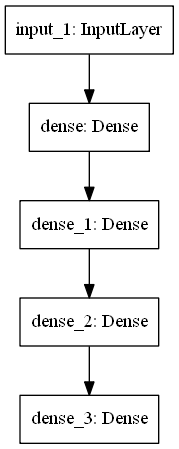

In [7]:
net_u.summary()

tf.keras.utils.plot_model(net_u)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


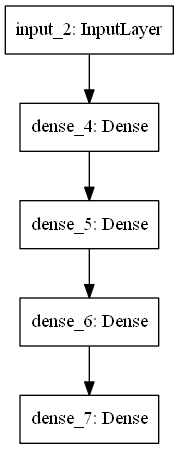

In [8]:
net_v.summary()

tf.keras.utils.plot_model(net_v)

### Build up the PINN

#### First define functions to perform automatic differentiation

In [9]:
class Dif_x(tf.keras.layers.Layer):
    """
    ====================================================================================================================

    This is the class for calculating the differential terms of the FNN's output with respect to the FNN's input. We
    adopt the GradientTape function provided by the TensorFlow library to do the automatic differentiation.
    This class include 2 functions, including:
        1. __init__()         : Initialise the parameters for differential operator;
        2. call()             : Calculate the differential terms.

    ====================================================================================================================
    """

    def __init__(self, fnn, **kwargs):
        """
        ================================================================================================================

        This function is to initialise for differential operator.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [fnn]       [Keras model]           : The Feedforward Neural Network.

        ================================================================================================================
        """
        self.fnn = fnn
        super().__init__(**kwargs)
    
    @tf.function
    def call(self, xy):
        """
        ================================================================================================================

        This function is to calculate the differential terms.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [xy]        [Keras model]           : The coordinate array;
        [temp]      [Keras tensor]          : The intermediate output from the FNN;
        [U]         [Keras tensor]          : The displacement predictions;
        [U_x]       [Keras tensor]          : The first-order derivative of the u with respect to the x;
        [U_y]       [Keras tensor]          : The first-order derivative of the u with respect to the y;
        [U_xx]      [Keras tensor]          : The second-order derivative of the u with respect to the x;
        [U_xy]      [Keras tensor]          : The second-order derivative of the u with respect to the xy;
        [U_yy]      [Keras tensor]          : The second-order derivative of the u with respect to the y.

        ================================================================================================================
        """

        ### Divide the coordinate array into x and y components
        x, y = (xy[..., i, tf.newaxis] for i in range(xy.shape[-1]))

        ### Apply the GradientTape function
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)

                ### Obtain the intermediate output from the FNN
                temp = self.fnn(tf.concat([x, y], axis=-1))

                ### Calculate the displacement output by times the coordinate to naturally satisfy the displacement
                ### boundary condition
                U = temp * x

            ### Obtain the first-order derivative of the output with respect to the input
            U_x = g.gradient(U, x)
            U_y = g.gradient(U, y)
            del g

        ### Obtain the second-order derivative of the output with respect to the input
        U_xx = gg.gradient(U_x, x)
        U_xy = gg.gradient(U_x, y)
        U_yy = gg.gradient(U_y, y)
        del gg

        return U_x, U_y, U_xx, U_xy, U_yy

In [10]:
class Dif_y(tf.keras.layers.Layer):
    """
            ====================================================================================================================

            This is the class for calculating the differential terms of the FNN's output with respect to the FNN's input. We
            adopt the GradientTape function provided by the TensorFlow library to do the automatic differentiation.
            This class include 2 functions, including:
                1. __init__()         : Initialise the parameters for differential operator;
                2. call()             : Calculate the differential terms.

            ====================================================================================================================
        """

    def __init__(self, fnn, **kwargs):
        """
        ================================================================================================================

        This function is to initialise for differential operator.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [fnn]       [Keras model]           : The Feedforward Neural Network.

        ================================================================================================================
        """
        self.fnn = fnn
        super().__init__(**kwargs)
    
    @tf.function
    def call(self, xy):
        """
        ================================================================================================================

        This function is to calculate the differential terms.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [xy]        [Keras model]           : The coordinate array;
        [temp]      [Keras tensor]          : The intermediate output from the FNN;
        [V]         [Keras tensor]          : The displacement predictions;
        [V_x]       [Keras tensor]          : The first-order derivative of the v with respect to the x;
        [V_y]       [Keras tensor]          : The first-order derivative of the v with respect to the y;
        [V_xx]      [Keras tensor]          : The second-order derivative of the v with respect to the x;
        [V_xy]      [Keras tensor]          : The second-order derivative of the v with respect to the xy;
        [V_yy]      [Keras tensor]          : The second-order derivative of the v with respect to the y.

        ================================================================================================================
        """

        ### Divide the coordinate array into x and y components
        x, y = (xy[..., i, tf.newaxis] for i in range(xy.shape[-1]))

        ### Apply the GradientTape function
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)

                ### Obtain the intermediate output from the FNN
                temp = self.fnn(tf.concat([x, y], axis=-1))

                ### Calculate the displacement output by times the coordinate to naturally satisfy the displacement
                ### boundary condition
                V = temp * y

            ### Obtain the first-order derivative of the output with respect to the input
            V_x = g.gradient(V, x)
            V_y = g.gradient(V, y)
            del g

        ### Obtain the second-order derivative of the output with respect to the input
        V_xx = gg.gradient(V_x, x)
        V_xy = gg.gradient(V_x, y)
        V_yy = gg.gradient(V_y, y)
        del gg

        return V_x, V_y, V_xx, V_xy, V_yy

#### Definition of the constitutive model, relating displacements to strains

In [11]:
def Material(U_x, U_y, V_x, V_y, U_xx, U_xy, U_yy, V_xx, V_xy, V_yy, E, mu, p):
    """
    ====================================================================================================================

    This function is to calculate the strain and stress based on the constitutive equation.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [U_x]       [Keras tensor]          : First-order derivative of displacement u with respect to x direction;
    [U_y]       [Keras tensor]          : First-order derivative of displacement u with respect to y direction;
    [U_xx]      [Keras tensor]          : Second-order derivative of displacement u with respect to x direction;
    [U_xy]      [Keras tensor]          : Second-order derivative of displacement u with respect to x and y directions;
    [U_yy]      [Keras tensor]          : Second-order derivative of displacement u with respect to y direction;
    [V_x]       [Keras tensor]          : First-order derivative of displacement u with respect to x direction;
    [V_y]       [Keras tensor]          : First-order derivative of displacement u with respect to y direction;
    [V_xx]      [Keras tensor]          : Second-order derivative of displacement u with respect to x direction;
    [V_xy]      [Keras tensor]          : Second-order derivative of displacement u with respect to x and y directions;
    [V_yy]      [Keras tensor]          : Second-order derivative of displacement u with respect to y direction;
    [e1]        [Keras tensor]          : Normal strain for x direction;
    [e2]        [Keras tensor]          : Normal strain for y direction;
    [e12]       [Keras tensor]          : Shear strain;
    [s1]        [Keras tensor]          : Normal stress for x direction;
    [s2]        [Keras tensor]          : Normal stress for y direction;
    [s12]       [Keras tensor]          : Shear stress;
    [Gex]       [Keras tensor]          : Residual from the equilibrium equation for x direction;
    [Gey]       [Keras tensor]          : Residual from the equilibrium equation for y direction;
    [E]         [float]                 : Young's module;
    [mu]        [float]                 : Poisson ratio；
    [la]        [float]                 : First lame constant;
    [nu]        [float]                 : Second lame constant.

    ====================================================================================================================
    """
    
    if p == 'plain_strain':
        ### plain strain
        la = E * mu/(1 + mu) / (1 - 2 * mu)
        nu = E / (1 + mu) / 2 
    elif p == 'plain_stress':
        ### plain stress
        la = E * mu/(1 + mu) / (1 - mu)
        nu = E / (1 + mu) / 2
    else:
        print('-------------------------------------------------\n')
        print('Material property error!\n')
        print('-------------------------------------------------\n')
        print('Please select the one of the following options:\n1.\tplain_strain\n2.\tplain_stress\n')
        print('-------------------------------------------------\n')
    
    ### Calculate strain
    e1 = U_x
    e2 = V_y
    e12 = 0.5 * (U_y + V_x)
    
    ### Calculate stress
    s1 = (2 * nu + la) * e1 + la * e2
    s2 = (2 * nu + la) * e2 + la * e1
    s12 = 2 * nu * e12
    
    ### Calculate the residual from equilibrium equation
    Gex = (2 * nu + la) * U_xx + nu * U_yy + (nu + la) * V_xy
    Gey = (nu + la) * U_xy + (2 * nu + la) * V_yy + nu * V_xx
    
    return e1, e2, e12, s1, s2, s12, Gex, Gey

#### Function to build the PINN

In [12]:
def PINN(net_u, net_v, E, mu):
    """
    ====================================================================================================================

    This function is to initialize a PINN.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [net_u]     [keras model]           : The trained FNN for displacement u;
    [xy]        [Array of float32]      : Coordinates of all the sample points;
    [xy_u]      [Array of float32]      : Coordinates of the sample points on the upper boundary of the plate;
    [xy_b]      [Array of float32]      : Coordinates of the sample points on the bottom boundary of the plate;
    [xy_l]      [Array of float32]      : Coordinates of the sample points on the left boundary of the plate;
    [xy_r]      [Array of float32]      : Coordinates of the sample points on the right boundary of the plate;

    [s_u_x]     [Array of float32]      : x direction force boundary condition on the top boundary of the plate;
    [s_u_y]     [Array of float32]      : y direction force boundary condition on the top boundary of the plate;
    [s_b_x]     [Array of float32]      : x direction force boundary condition on the bottom boundary of the plate;
    [s_b_y]     [Array of float32]      : y direction force boundary condition on the bottom boundary of the plate;
    [s_l_x]     [Array of float32]      : x direction force boundary condition on the left boundary of the plate;
    [s_l_y]     [Array of float32]      : y direction force boundary condition on the left boundary of the plate;
    [s_r_x]     [Array of float32]      : x direction force boundary condition on the right boundary of the plate;
    [s_r_y]     [Array of float32]      : y direction force boundary condition on the right boundary of the plate;
    [Gex]       [Keras tensor]          : Residual from the equilibrium equation for x direction;
    [Gey]       [Keras tensor]          : Residual from the equilibrium equation for y direction;
    [sigma_r]   [Keras tensor]          : Stress at the right tip of the rod;
    [E]         [float]                 : Young's module;
    [mu]        [float]                 : Poisson ratio.

    ====================================================================================================================
    """

    ### declare PINN's inputs
    xy = tf.keras.layers.Input(shape=(2,))
    xy_u = tf.keras.layers.Input(shape=(2,))
    xy_b = tf.keras.layers.Input(shape=(2,))
    xy_l = tf.keras.layers.Input(shape=(2,))
    xy_r = tf.keras.layers.Input(shape=(2,))
    
    ### initialize the differential operators
    dif_x = Dif_x(net_u)
    dif_y = Dif_y(net_v)
    
    ### obtain partial derivatives of u with respect to x and y
    U_x, U_y, U_xx, U_xy, U_yy = dif_x(xy)
    V_x, V_y, V_xx, V_xy, V_yy = dif_y(xy)
    U_u_x, U_u_y, U_u_xx, U_u_xy, U_u_yy = dif_x(xy_u)
    V_u_x, V_u_y, V_u_xx, V_u_xy, V_u_yy = dif_y(xy_u)
    U_b_x, U_b_y, U_b_xx, U_b_xy, U_b_yy = dif_x(xy_b)
    V_b_x, V_b_y, V_b_xx, V_b_xy, V_b_yy = dif_y(xy_b)
    U_l_x, U_l_y, U_l_xx, U_l_xy, U_l_yy = dif_x(xy_l)
    V_l_x, V_l_y, V_l_xx, V_l_xy, V_l_yy = dif_y(xy_l) 
    U_r_x, U_r_y, U_r_xx, U_r_xy, U_r_yy = dif_x(xy_r)
    V_r_x, V_r_y, V_r_xx, V_r_xy, V_r_yy = dif_y(xy_r) 
       
    ### Obtain the residuals from stress boundary conditions
    p = 'plain_stress'
    _, _, _, _, _, _, Gex, Gey = Material(U_x, U_y, V_x, V_y, U_xx, U_xy, U_yy, V_xx, V_xy, V_yy, E, mu, p)
    _, _, _, _, s_u_y, s_u_x, _, _ = Material(U_u_x, U_u_y, V_u_x, V_u_y, U_u_xx, U_u_xy, U_u_yy, V_u_xx, V_u_xy, V_u_yy, E, mu, p)
    _, _, _, _, s_b_y, s_b_x, _, _ = Material(U_b_x, U_b_y, V_b_x, V_b_y, U_b_xx, U_b_xy, U_b_yy, V_b_xx, V_b_xy, V_b_yy, E, mu, p)
    _, _, _, s_l_x, _, s_l_y, _, _ = Material(U_l_x, U_l_y, V_l_x, V_l_y, U_l_xx, U_l_xy, U_l_yy, V_l_xx, V_l_xy, V_l_yy, E, mu, p)
    _, _, _, s_r_x, _, s_r_y, _, _ = Material(U_r_x, U_r_y, V_r_x, V_r_y, U_r_xx, U_r_xy, U_r_yy, V_r_xx, V_r_xy, V_r_yy, E, mu, p)

    ### build up the PINN
    pinn = tf.keras.models.Model(inputs = [xy, xy_u, xy_b, xy_l, xy_r], \
            outputs = [Gex, Gey, s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y])

    return pinn

#### PINN and its summary

In [13]:
pinn = PINN(net_u, net_v, E, mu)

pinn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
____________________________________________________________________________________________

#### Loss Function

In [14]:
def Collocation_Loss(y_p, y):
    """
    ====================================================================================================================

    Collocation loss function

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [y_p]       [list]                  : Outputs from the PINN;
    [y]         [list]                  : The ground truth data;
    [l1]        [Keras tensor]          : The loss term from the equilibrium equation;
    [l2]        [Keras tensor]          : The loss term from the traction boundary condition;
    [loss]      [Keras tensor]          : The final loss

    ====================================================================================================================
    """

    ### Residual from the governing equation
    l1 = (tf.reduce_mean(tf.square(y_p[0])) + \
        tf.reduce_mean(tf.square(y_p[1])))

    ### Residual from the traction boundary condition
    l2 = ((tf.reduce_mean(tf.square(y_p[2]-y[0])) + \
        tf.reduce_mean(tf.square(y_p[3]-y[1]))) + \
        tf.reduce_mean(tf.square(y_p[4]-y[2])) + \
        tf.reduce_mean(tf.square(y_p[7]-y[5])) + \
        (tf.reduce_mean(tf.square(y_p[8]-y[6])) + \
        tf.reduce_mean(tf.square(y_p[9]-y[7]))))

    ### Final loss
    loss = l1 + l2

    return loss, l1, l2

### Initialize the L-BFGS-B optimiser

In [15]:
class L_BFGS_B:
    """
        ====================================================================================================================

        This is the class for the L-BFGS-B optimiser. We adopt core algorithm of the L-BFGS-B algorithm is provided by the
        Scipy library. This class include 5 functions, including:
            1. __init__()         : Initialise the parameters for the L-BFGS-B optimiser;
            2. pi_loss()          : Calculate the physics-informed loss;
            3. loss_grad()        : Obtain the gradients of the physics-informed loss with respect to the weighs and biases;
            4. set_weights()      : Set the modified weights and biases back to the neural network structure;
            5. fit()              : Execute training process.

        ====================================================================================================================
    """

    def __init__(self, pinn, x_train, y_train, dx, factr=10, pgtol=1e-10, m=50, maxls=50, maxfun=40000):
        """
        ================================================================================================================

        This function is to initialise the parameters used in the L-BFGS-B optimiser.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [dx]        [float]                 : Sample points interval;
        [factr]     [int]                   : The optimiser option. Please refer to SciPy;
        [pgtol]     [float]                 : The optimiser option. Please refer to SciPy;
        [m]         [int]                   : The optimiser option. Please refer to SciPy;
        [maxls]     [int]                   : The optimiser option. Please refer to SciPy;
        [maxfun]    [int]                   : Maximum number of iterations for training;
        [iter]      [int]                   : Number of training iterations;
        [his_l1]    [list of float32]       : History values of the l1 loss term;
        [his_l2]    [list of float32]       : History values of the l1 loss term.

        ================================================================================================================
        """

        ### Initialise the parameters
        self.pinn = pinn
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.dx = dx
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxfun = maxfun
        self.metrics = ['loss']
        self.iter = 0
        self.his_loss_ge = []
        self.his_loss_bc = []

    def pi_loss(self, weights):
        """
        ================================================================================================================

        This function is to calculate the physics-informed loss.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [weights]   [list]                  : The weights and biases;
        [pinn]      [Keras tensor]          : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [loss]      [Keras tensor]          : Current value of the physics-informed loss;
        [l1]        [Keras tensor]          : The l1 loss term;
        [l2]        [Keras tensor]          : The l2 loss term;
        [grads]     [Keras tensor]          : The gradients of the physics-informed loss with respect to weights and
                                              biases;
        [iter]      [int]                   : Number of training iterations.

        ================================================================================================================
        """

        ### Update the weights and biases to the FNN
        self.set_weights(weights)

        ### Calculate the physics-informed loss and its gradients with respect to weights and biases
        loss, grads, l1, l2 = self.loss_grad(self.x_train, self.y_train)

        ### Count number of the training iteration
        self.iter = self.iter + 1.

        ### Print the loss terms every 10 training iterations
        if self.iter % 10 == 0:
            print('Iter: %d   L1 = %.4g   L2 = %.4g' % (self.iter, l1.numpy(), l2.numpy()))

        ### Convert loss and grads from Keras tensor to ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')

        ### Save the current loss term in different np.array
        self.his_loss_ge.append(l1)
        self.his_loss_bc.append(l2)

        return loss, grads

    @tf.function
    def loss_grad(self, x, y):
        """
        ================================================================================================================

        This function is to obtain the gradients of the physics-informed loss with respect to the weighs and biases.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [y_p]       [list]                  : List of predictions from the PINN;
        [loss]      [Keras tensor]          : Current value of the physics-informed loss;
        [l1]        [Keras tensor]          : The l1 loss term;
        [l2]        [Keras tensor]          : The l2 loss term;
        [dx]        [float]                 : Sample points interval;
        [grads]     [Keras tensor]          : The gradients of the physics-informed loss with respect to weights and
                                              biases.

        ================================================================================================================
        """

        with tf.GradientTape() as g:

            ### Predict outputs from the current PINN
            y_p = self.pinn(x)

            ### Apply the collocation loss function
            loss, l1, l2 = Collocation_Loss(y_p, y)

        ### Obtain the gradients through automatic differentiation
        ### (GradientTape function provided by the TensorFlow)
        grads = g.gradient(loss, self.pinn.trainable_variables)

        return loss, grads, l1, l2

    def set_weights(self, flat_weights):
        """
        ================================================================================================================

        This function is to Set the modified weights and biases back to the neural network structure.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [keras model]           : The Physics-informed neural network;
        [shapes]    [list]                  : The shapes of neural network's weights and biases;
        [weights]   [list]                  : The weights and biases.

        ================================================================================================================
        """

        ### Obtain the shapes of neural network's weights and biases
        shapes = [w.shape for w in self.pinn.get_weights()]

        ### Compute splitting indices
        split_ids = np.cumsum([np.prod(shape) for shape in [0] + shapes])

        ### Reshape the modified weights and biases to fit the neural network structure
        weights = [flat_weights[from_id:to_id].reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]

        ### Set weights and biases to the neural network
        self.pinn.set_weights(weights)

        return None

    def fit(self):
        """
        ================================================================================================================

        This function is to execute training process.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [ini_w]     [ndarray]               : The initial weights and biases;
        [pi_loss]   [function]              : The function that calculates the physics-informed loss (line 61);
        [factr]     [int]                   : The optimiser option. Please refer to SciPy;
        [pgtol]     [float]                 : The optimiser option. Please refer to SciPy;
        [m]         [int]                   : The optimiser option. Please refer to SciPy;
        [maxls]     [int]                   : The optimiser option. Please refer to SciPy;
        [maxfun]    [int]                   : Maximum number of iterations for training;
        [result]    [tuple]                 : The result returned by the optimiser;
        [his_l1]    [list of float32]       : History values of the l1 loss term;
        [his_l2]    [list of float32]       : History values of the l2 loss term.

        ================================================================================================================
        """

        ### Get initial weights and biases
        initial_weights = np.concatenate([ w.flatten() for w in self.pinn.get_weights() ])

        ### Optimise the weights and biases via the L-BFGS-B optimiser
        print('Optimizer: L-BFGS-B (Provided by Scipy package)')
        print('Initializing ...')
        result = scipy.optimize.fmin_l_bfgs_b(func=self.pi_loss, x0=initial_weights,
            factr=self.factr, pgtol=self.pgtol, m=self.m, maxls=self.maxls, maxfun=self.maxfun)

        return result, [np.array(self.his_loss_ge), np.array(self.his_loss_bc)]

In [16]:
l_bfgs_b = L_BFGS_B(pinn, x_train, y_train, dx)

## Training using the BFGS optimizer

In [17]:
    """
    ====================================================================================================================

    Train function is to train the neural networks with the selected optimizer.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [result]    [tuple]                 : The result returned by the optimiser;
    [his_loss]  [list]                  : History values of the loss terms;
    [t]         [float]                 : CPU time used for training;
    [l]         [float]                 : Final loss;
    [it]        [int]                   : The number of iterations for convergence.

    ====================================================================================================================
    """

time_start = time.time()
hist, his_loss = l_bfgs_b.fit()
time_end = time.time()
    
T = time_end-time_start
L = hist[1]
it = hist[2]['funcalls']
    
print('*************************************************\n')
print('Time cost is', T, 's')
print('Final loss is', L, '')
print('Training converges by', it, 'iterations\n')
print('*************************************************\n')
    
#    return T, L, it, his_loss

Optimizer: L-BFGS-B (Provided by Scipy package)
Initializing ...
Iter: 10   L1 = 0.1821   L2 = 0.09658
Iter: 20   L1 = 0.05599   L2 = 0.03296
Iter: 30   L1 = 0.02306   L2 = 0.02654
Iter: 40   L1 = 0.01563   L2 = 0.02269
Iter: 50   L1 = 0.01175   L2 = 0.01594
Iter: 60   L1 = 0.01058   L2 = 0.0131
Iter: 70   L1 = 0.008869   L2 = 0.01096
Iter: 80   L1 = 0.007497   L2 = 0.009818
Iter: 90   L1 = 0.008434   L2 = 0.00647
Iter: 100   L1 = 0.007753   L2 = 0.00407
Iter: 110   L1 = 0.005983   L2 = 0.003518
Iter: 120   L1 = 0.004395   L2 = 0.002895
Iter: 130   L1 = 0.003396   L2 = 0.002493
Iter: 140   L1 = 0.002966   L2 = 0.002232
Iter: 150   L1 = 0.002507   L2 = 0.00201
Iter: 160   L1 = 0.002364   L2 = 0.001825
Iter: 170   L1 = 0.001924   L2 = 0.00196
Iter: 180   L1 = 0.00189   L2 = 0.00177
Iter: 190   L1 = 0.001833   L2 = 0.001695
Iter: 200   L1 = 0.001668   L2 = 0.001478
Iter: 210   L1 = 0.001572   L2 = 0.00145
Iter: 220   L1 = 0.00148   L2 = 0.001349
Iter: 230   L1 = 0.001368   L2 = 0.001307
I

Iter: 1870   L1 = 9.567e-05   L2 = 0.0001147
Iter: 1880   L1 = 9.732e-05   L2 = 0.0001124
Iter: 1890   L1 = 9.7e-05   L2 = 0.0001122
Iter: 1900   L1 = 9.786e-05   L2 = 0.0001106
Iter: 1910   L1 = 9.67e-05   L2 = 0.0001113
Iter: 1920   L1 = 9.662e-05   L2 = 0.0001111
Iter: 1930   L1 = 9.612e-05   L2 = 0.0001113
Iter: 1940   L1 = 9.495e-05   L2 = 0.000112
Iter: 1950   L1 = 9.583e-05   L2 = 0.0001108
Iter: 1960   L1 = 9.555e-05   L2 = 0.0001108
Iter: 1970   L1 = 9.535e-05   L2 = 0.0001108
Iter: 1980   L1 = 9.561e-05   L2 = 0.00011
Iter: 1990   L1 = 9.496e-05   L2 = 0.0001099
Iter: 2000   L1 = 9.493e-05   L2 = 0.0001089
Iter: 2010   L1 = 9.54e-05   L2 = 0.0001077
Iter: 2020   L1 = 9.512e-05   L2 = 0.0001071
Iter: 2030   L1 = 9.535e-05   L2 = 0.0001046
Iter: 2040   L1 = 9.474e-05   L2 = 0.0001031
Iter: 2050   L1 = 9.298e-05   L2 = 0.0001015
Iter: 2060   L1 = 9.048e-05   L2 = 0.0001029
Iter: 2070   L1 = 8.717e-05   L2 = 0.0001041
Iter: 2080   L1 = 8.558e-05   L2 = 0.0001043
Iter: 2090   L1 =

## Post-Processing

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


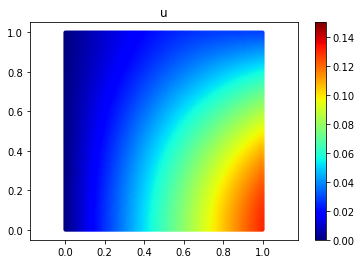

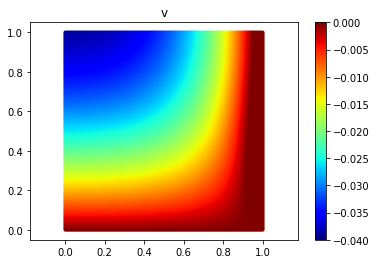

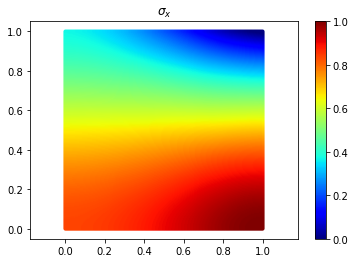

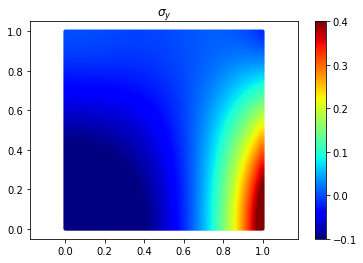

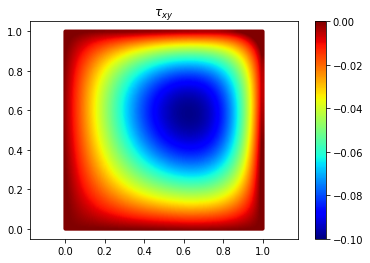

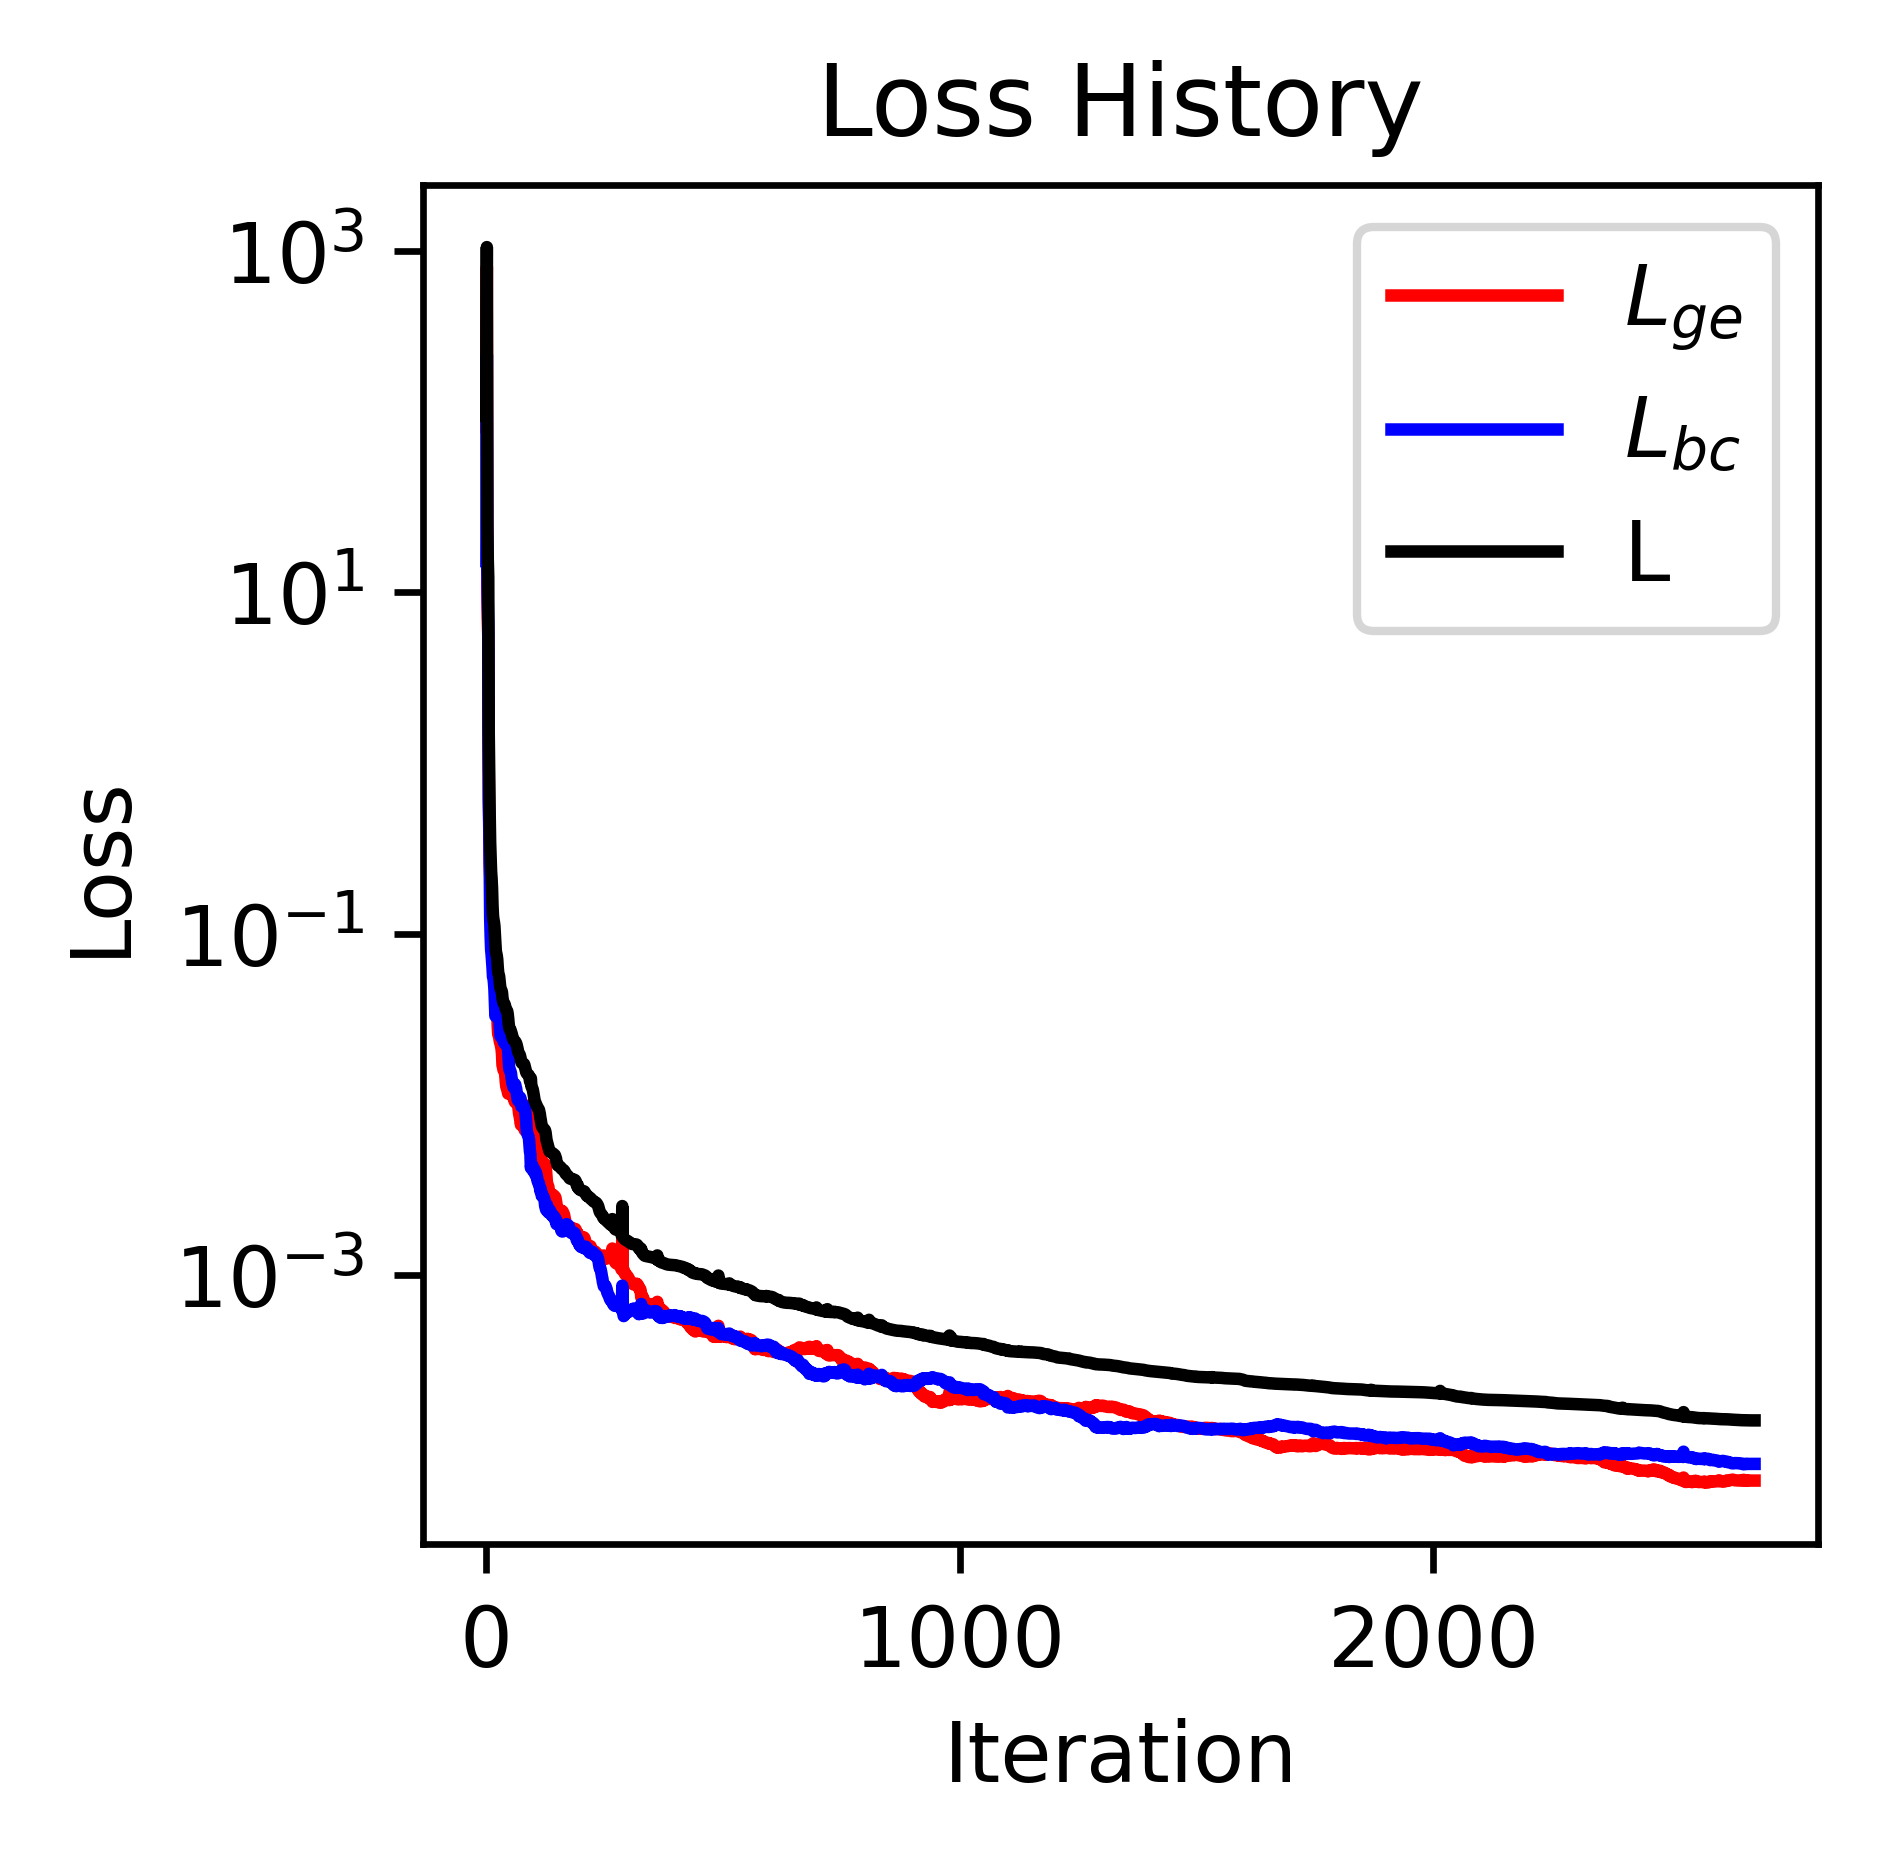

In [18]:
"""
===================================================================================================================

Post_Process function is to:
    1. Visualize the displacement, strain, and stress;
    2. Output results.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.
    
    [xy]        [array of float]        : Coordinates of all the sample points;
    [u]         [array of float]        : Displacement in x direction;
    [v]         [array of float]        : Displacement in y direction;
    [s11]       [array of float]        : Normal Stress in x direction;
    [s22]       [array of float]        : Normal Stress in y direction;
    [s12]       [array of float]        : Shear Stress on xy plane;
    [net_u]     [keras model]           : The trained FNN for displacement u;
    [net_v]     [keras model]           : The trained FNN for displacement v;
    [pinn]      [Keras model]           : The Physics-Informed Neural Network;
    [his_loss]  [list]                  : History values of the loss terms.

====================================================================================================================
"""

xy = np.zeros((201*201, 2)).astype(np.float32)
k = 0
for i in range(0,201):
    for j in range(0,201):
        xy[k, 0] = i * 1/200
        xy[k, 1] = j * 1/200
        k = k+1
    
u = net_u.predict(xy) * xy[..., 0, np.newaxis]
v = net_v.predict(xy) * xy[..., 1, np.newaxis]
temp = pinn.predict([ xy for i in range(0,5) ])
s11 = temp[6]
s22 = temp[3]
s12 = temp[2]
    
### plot figure for displacement u
fig1 = plt.figure(1)
plt.scatter(xy[:,0], xy[:,1], s = 5, c = u, cmap = 'jet', vmin = 0, vmax = 0.15)
plt.axis('equal')
plt.colorbar()
plt.title('u')
plt.savefig('u.tiff', dpi = 600)
    
### plot figure for displacement v
fig2 = plt.figure(2)
plt.scatter(xy[:,0], xy[:,1], s = 5, c = v, cmap = 'jet', vmin = -4e-2, vmax = 0)
plt.axis('equal')
plt.colorbar()
plt.title('v')
plt.savefig('v.tiff', dpi = 600)
    
### plot figure for stress sigma_x
fig3 = plt.figure(3)
plt.scatter(xy[:,0], xy[:,1], s = 5, c = s11, cmap = 'jet', vmin = 0, vmax = 1)
plt.axis('equal')
plt.colorbar()
plt.title(r'$\sigma_{x}$')
plt.savefig('sigma_x.tiff', dpi = 600)
    
### plot figure for stress sigma_y
fig4 = plt.figure(4)
plt.scatter(xy[:,0], xy[:,1], s = 5, c = s22, cmap = 'jet', vmin = -0.1, vmax = 0.4)
plt.axis('equal')
plt.colorbar()
plt.title(r'$\sigma_{y}$')
plt.savefig('sigma_y.tiff', dpi = 600)
    
### plot figure for stress tau_xy
fig5 = plt.figure(5)
plt.scatter(xy[:,0], xy[:,1], s = 5, c = s12, cmap = 'jet', vmin = -0.1, vmax = 0)
plt.axis('equal')
plt.colorbar()
plt.title(r'$\tau_{xy}$')
plt.savefig('tau_xy.tiff', dpi = 600)
    
### plot figure for hist_loss
fig6 = plt.figure(6, figsize=(3,3), dpi = 600)
plt.plot(his_loss[0], color = 'r')
plt.plot(his_loss[1], color = 'b')
plt.plot(his_loss[0] + his_loss[1], color = 'k')
plt.yscale('log')
plt.xlabel('Iteration', fontdict = {'fontname': 'Helvetica'})
plt.ylabel('Loss', fontdict = {'fontname': 'Helvetica'})
plt.title('Loss History', fontdict = {'fontname': 'Helvetica'})
plt.legend(['$L_{ge}$', '$L_{bc}$', 'L'])
plt.savefig('hist_loss.tiff', dpi = 600, bbox_inches = 'tight')
plt.show()
    
### output data in the 'out.mat' file
# scipy.io.savemat('out.mat', {'xy': xy, 'u': np.hstack([u,v]), 's11': s11, 's22': s22, 's12': s12})